# Introduction

Time series is the model that being applied with a time element, and a time series model is to makes predictions based on the assumption that patterns in the past will repeat in the future. The goal of this notebook is to apply ARIMA, SARIMA (SARIMAX) on 2 different dataset to understand to model and chose the best fit model for the datasets. The datasets used for this notebook are Minimum Daily Temperatures Datasets (univariate dataset) and Occupancy Detection Dataset (multivariate dataset).

In [54]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import seaborn as sns
from pandas import read_csv
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from prophet import Prophet

# Univariate: Minimum Daily Temperatures Datasets

In [55]:
column_names = ['Date', 'Temp']
min_temp = pd.read_csv(r'C:\Users\minhh\OneDrive\Desktop\ML\Exercise\Timeseries\daily-min-temperatures.csv',index_col=0,parse_dates=True, names= column_names,skiprows=[0] )
min_temp = min_temp.dropna()
min_temp.reset_index()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [56]:
min_temp.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [57]:
min_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


### Data Preprocessing and Initial Analysis 

Plotting the data to check how it is:

<AxesSubplot:xlabel='Date'>

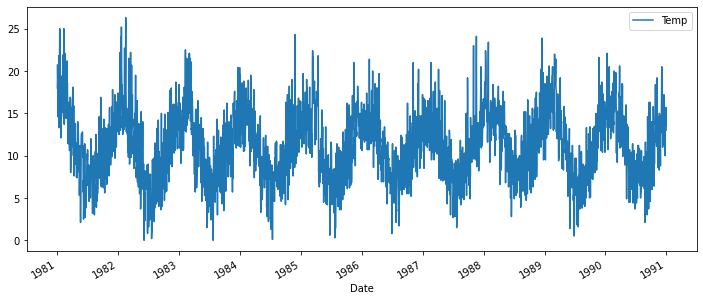

In [58]:
min_temp.plot(figsize=(12,5))

Here, by the visualization, we can see the seasonality in the data set. In the graph, the magnitude of the minimum temperature is changed repeatedly, showing the changes almost similar for different time intervals.

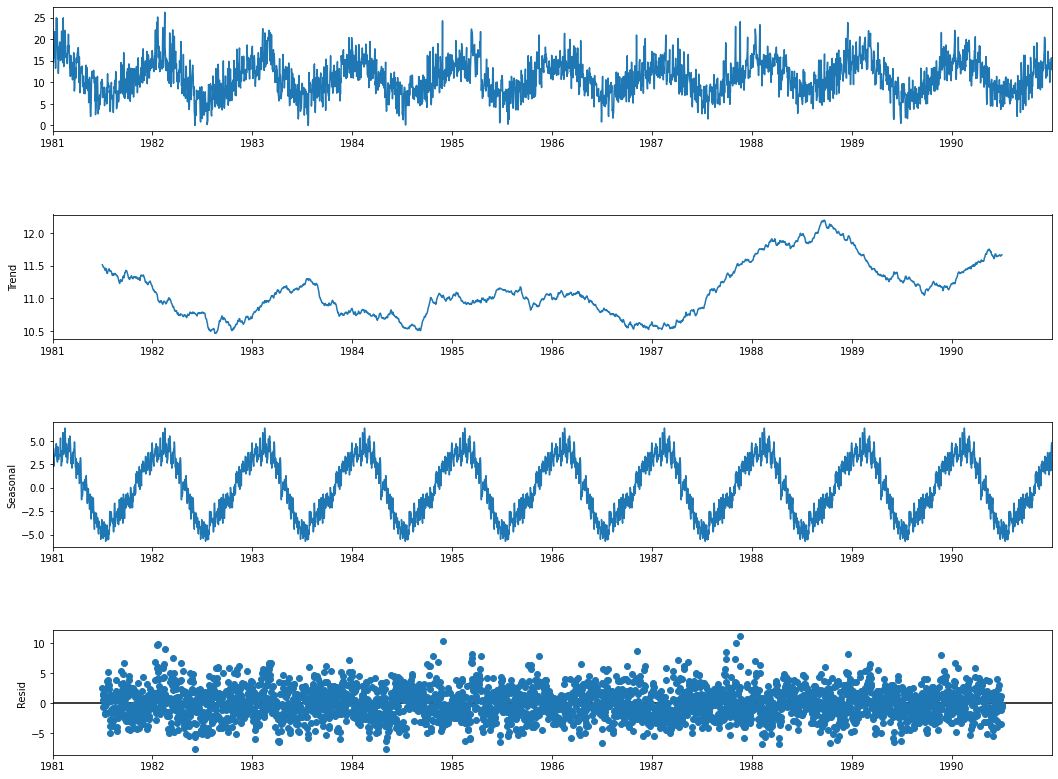

In [59]:
result = seasonal_decompose(min_temp, model='additive', freq=365)
fig = result.plot()
fig.set_size_inches(16, 12)

#### Test for stationarity

The stationarity and seasonal factor is an important piece of information because it represents the repeating patterns that affect time series. Finding out the rules of time series according to cycles and seasons will help us forecast more accurately. Check of the data is stationary or not by running a statistical analysis test known as dickey-fuller test:

In [60]:
#creating a function for values 
def adf_test(dataset):
   dftest = adfuller(dataset, autolag = 'AIC')
   print("1. ADF : ",dftest[0])
   print("2. P-Value : ", dftest[1])
   print("3. Num Of Lags : ", dftest[2])
   print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
   print("5. Critical Values :")
   for key, val in dftest[4].items():
       print("\t",key, ": ", val)
 #printing for AvgTemp
adf_test(min_temp)

1. ADF :  -4.444804924611681
2. P-Value :  0.00024708263003611787
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 3629
5. Critical Values :
	 1% :  -3.4321532327220154
	 5% :  -2.862336767636517
	 10% :  -2.56719413172842


With the observed p-value, we can state that the data is stationary. Hence, we can apply ARIMA model.

###  Creating Arima Model

To choose the best model (p,d,q) we can based solely on AIC index. This process can be automated using pyramic
package.

In [61]:
stepwise_fit = auto_arima(min_temp, trace=True, suppress_warnings=True)
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=16781.136, Time=2.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20611.139, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17265.725, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18554.160, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28436.596, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=16816.370, Time=1.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16831.033, Time=1.97 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=16780.221, Time=3.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=16777.600, Time=2.76 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=17113.438, Time=0.68 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=16779.598, Time=3.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=17245.958, Time=0.48 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=17030.851, Time=0.88 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=16781.448, Time=2.29 sec
 ARIMA(3,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3650
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -8382.800
Date:                Sun, 21 Nov 2021   AIC                          16777.600
Time:                        20:10:44   BIC                          16814.815
Sample:                             0   HQIC                         16790.853
                               - 3650                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0562      0.018      3.127      0.002       0.021       0.091
ar.L1          1.4851      0.018     80.343      0.000       1.449       1.521
ar.L2         -0.6204      0.027    -23.368      0.000      -0.672      -0.568
ar.L3          0.1303      0.018      7.386      0.000       0.096       0.165
ma.L1         -0.8928      0.012    -76.064      0.000      -0.916      -0.870
sigma2         5.7831      0.128     45.331      0.000       5.533       6.033
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                16.70
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

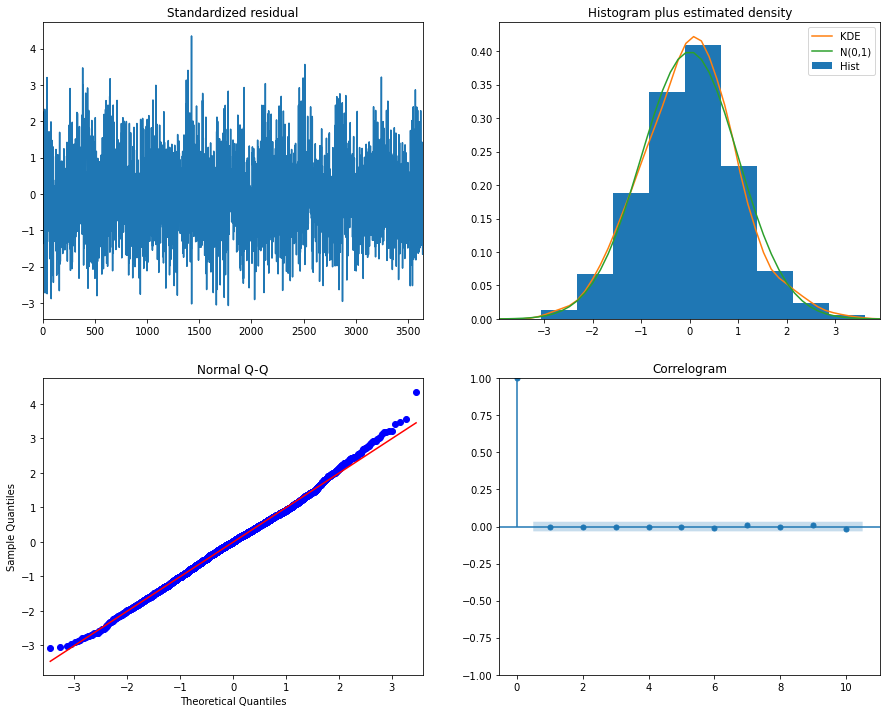

In [62]:
stepwise_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

The model diagnostics suggests that the model residuals are normally distributed.

In [63]:
 #splitting into train and test
print(min_temp.shape)
train=min_temp.iloc[:-730]
test=min_temp.iloc[-730:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1]) 

(3650, 1)
(2920, 1) (730, 1)
Temp    14.3
Name: 1989-01-01 00:00:00, dtype: float64 Temp    13.0
Name: 1990-12-31 00:00:00, dtype: float64


#create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [64]:
import warnings
warnings.filterwarnings("ignore")
model= ARIMA(train,order=(3,0,1))
model_fit=model.fit()

In [65]:
start = len(train)
end = len(test)+len(train)-1
pred = model_fit.predict(start=start, end=end,typ='levels').rename('ARIMA predictions')
pred.to_frame()

,ARIMA predictions
2920,14.280586
2921,14.443442
2922,14.484662
2923,14.469121
2924,14.441714
...,...
3645,11.523248
3646,11.523163
3647,11.523078
3648,11.522994


In [66]:
min_temp_index = min_temp.reset_index()
pred = pd.merge(min_temp_index, pred, left_index=True, right_index=True).set_index('Date')
pred = pred.drop(['Temp'],axis=1)

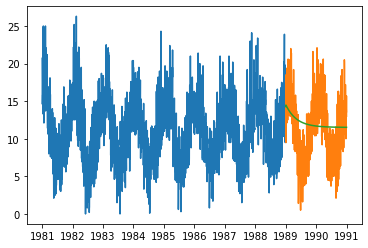

In [67]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred, label='Prediction')
plt.show()

Here we can easily see the results we have got by the model is very unsatisfactory. This is because we have fit the model with a non-stationary time series. Without the stationary data, the model is not going to perform well. 

Next, we are going to apply the model with the data after differencing the time series.

#### Test for seasonality 

<AxesSubplot:title={'center':'original'}, xlabel='Date'>

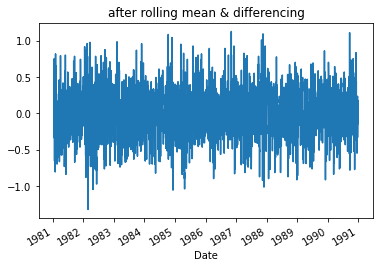

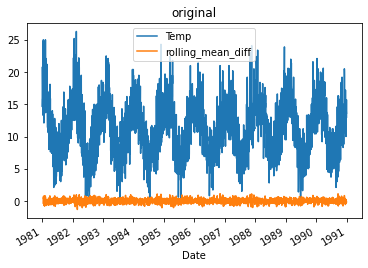

In [68]:
rolling_mean = min_temp.rolling(window = 12).mean()
min_temp['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
min_temp['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
min_temp.plot(title='original')

In [69]:
 #splitting into train and test
print(min_temp.shape)
train2=min_temp['rolling_mean_diff'].iloc[:-730].dropna()
test2=min_temp['rolling_mean_diff'].iloc[-730:].dropna()
print(train2.shape,test2.shape)
print(test2.iloc[0],test2.iloc[-1]) 

(3650, 2)
(2908,) (730,)
-0.049999999999998934 -0.14166666666666927


In [70]:
model2=ARIMA(min_temp['rolling_mean_diff'].dropna(),order=(3,0,1))
model_fit2=model2.fit()

In [71]:
pred2=model_fit2.predict(start=2920,end=3650,typ='levels').rename('ARIMA predictions 2')

In [72]:
min_temp_index2 = min_temp.reset_index()
pred2 = pd.merge(min_temp_index, pred2, left_index=True, right_index=True).set_index('Date')
pred2 = pred2.drop(['Temp'],axis=1)

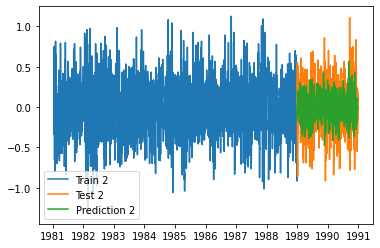

In [73]:
plt.plot(train2, label='Train 2')
plt.plot(test2, label='Test 2')
plt.plot(pred2, label='Prediction 2')
plt.legend()
plt.show()

# Multivariate: Occupancy Detection Dataset

## Data loading

In [74]:
datatest = pd.read_csv(r'C:\Users\minhh\OneDrive\Desktop\ML\Exercise\Timeseries\datatest.txt')
datatest2 = pd.read_csv(r'C:\Users\minhh\OneDrive\Desktop\ML\Exercise\Timeseries\datatest2.txt')
datatraining = pd.read_csv(r'C:\Users\minhh\OneDrive\Desktop\ML\Exercise\Timeseries\datatraining.txt')

For training and testing the models, datatraining(8143 instances) wil be used as training, datatest(2665 instances) as validation and datatest2(9752 instances) as test data.

Occupancy as either 1 for occupied or 0 for not occupied.

In [75]:
datatraining

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


## Missing value 

In [76]:
datatraining.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

## EDA

In [77]:
datatraining.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [78]:
datatest['date'] = pd.to_datetime(datatest['date'])
datatest2['date'] = pd.to_datetime(datatest2['date'])
datatraining['date'] = pd.to_datetime(datatraining['date'])
datatest.reset_index(drop=True, inplace=True)
datatest2.reset_index(drop=True, inplace=True)
datatraining.reset_index(drop=True, inplace=True)

In [79]:
datatraining

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8138,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8139,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8140,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8141,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [80]:
datatest

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.700000,26.272000,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.718000,26.290000,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.730000,26.230000,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.722500,26.125000,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.754000,26.200000,488.600000,779.000000,0.004767,1
...,...,...,...,...,...,...,...
2660,2015-02-04 10:38:59,24.290000,25.700000,808.000000,1150.250000,0.004829,1
2661,2015-02-04 10:40:00,24.330000,25.736000,809.800000,1129.200000,0.004848,1
2662,2015-02-04 10:40:59,24.330000,25.700000,817.000000,1125.800000,0.004841,1
2663,2015-02-04 10:41:59,24.356667,25.700000,813.000000,1123.000000,0.004849,1


### 1. Scaling

Since we have low values like humidity_ratio and high values like light and CO2, we should normalize the data to simplfy the learning process.

In [81]:
scaler = MinMaxScaler()
columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
scaler.fit(np.array(datatraining[columns]))
datatest[columns] = scaler.transform(np.array(datatest[columns]))
datatest2[columns] = scaler.transform(np.array(datatest2[columns]))
datatraining[columns] = scaler.transform(np.array(datatraining[columns]))

In [82]:
datatraining.drop(['date', 'Occupancy'],axis=1).describe()

,Temperature,Humidity,Light,CO2,HumidityRatio
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,0.387341,0.401676,0.077292,0.119942,0.312576
std,0.243281,0.247233,0.125947,0.194536,0.224186
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.167464,0.154431,0.000000,0.016246,0.106304
50%,0.332536,0.423623,0.000000,0.025220,0.296338
75%,0.571770,0.616307,0.165795,0.139925,0.441308
max,1.000000,1.000000,1.000000,1.000000,1.000000


### 2. Visualization 

plt.figure(figsize=(10,10))
plt.title(' Features boxplot')
ax = sns.boxplot(data=datatraining.drop(['date', 'Occupancy'],axis=1), orient="h", palette="Set2")

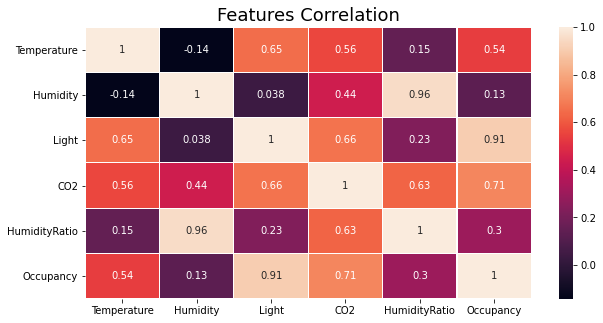

In [83]:
plt.figure(figsize=(10,5))
plt.title('Features Correlation', fontdict={'fontsize':18})
ax = sns.heatmap(datatraining.corr(), annot=True, linewidths=.2)

As shown on the heatmap, light and occupancy has high correlation (0.91), also CO2 and occupancy has relatively high correlation (0.71). Also, Humidity and HumidityRatio are highly correlated to each other (0.96). These variables are basically humidity so we can drop one:


In [84]:
datatraining = datatraining.drop('HumidityRatio', axis =1)
datatest = datatest.drop('HumidityRatio', axis =1)
datatest2 = datatest2.drop('HumidityRatio', axis =1)

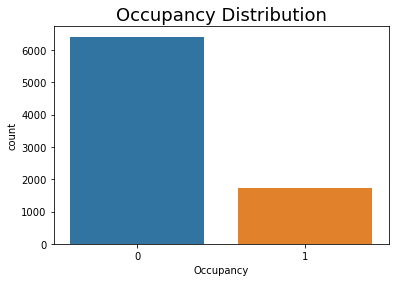

In [85]:
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
ax = sns.countplot(x="Occupancy", data=datatraining)

The data is unbalanced as there are more occupied than not occupied

In [86]:
datatraining

,date,Temperature,Humidity,Light,CO2,Occupancy
0,2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,1
1,2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,1
2,2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,1
3,2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,1
4,2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,1
...,...,...,...,...,...,...
8138,2015-02-10 09:29:00,0.490431,0.865013,0.280017,0.231781,1
8139,2015-02-10 09:29:59,0.490431,0.860431,0.280017,0.233173,1
8140,2015-02-10 09:30:59,0.502392,0.864901,0.280017,0.238744,1
8141,2015-02-10 09:32:00,0.502392,0.872276,0.280017,0.252256,1


In [87]:
hours_1 = []
hours_0 = []
for date in datatraining[datatraining['Occupancy'] == 1]['date']:
    hours_1.append(date.hour)
for date in datatraining[datatraining['Occupancy'] == 0]['date']:
    hours_0.append(date.hour)

In [88]:
hours_1

[17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11

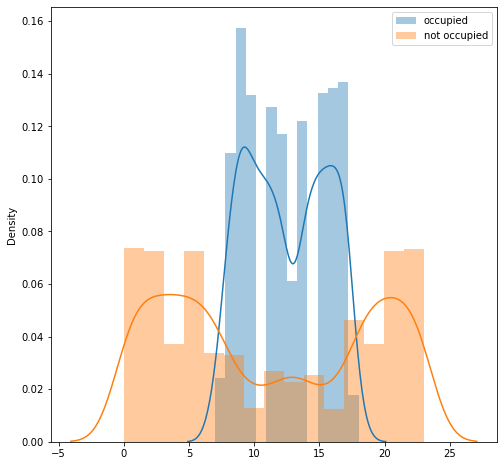

In [89]:
plt.figure(figsize=(8,8))
ax = sns.distplot(hours_1, label= 'occupied')
ax = sns.distplot(hours_0, label= 'not occupied')
ax.legend()

The histplot shows that there are more occupants from 7:00 to 18:00, and there are almost no occupant at other time of the day. It can be concluded that there is only occupation in working hours. So, we can take this into another variable.

There is no null value in the training dataset, so we can move on to the next step.

## ARIMA

In [90]:
datatraining=datatraining.set_index('date')
datatest =datatest.set_index('date')
datatest2 =datatest2.set_index('date')

### 1. Checking stationarity   

In [91]:
result = adfuller(datatraining['Occupancy'].values)
result

(-3.4303151431778196,
 0.009967833062453359,
 36,
 8106,
 {'1%': -3.431156979030426,
  '5%': -2.8618966275522464,
  '10%': -2.566959828094428},
 -20782.240963532586)

In [92]:
datatraining

,Temperature,Humidity,Light,CO2,Occupancy
date,,,,,
2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,1
2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,1
2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,1
2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,1
2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,1
...,...,...,...,...,...
2015-02-10 09:29:00,0.490431,0.865013,0.280017,0.231781,1
2015-02-10 09:29:59,0.490431,0.860431,0.280017,0.233173,1
2015-02-10 09:30:59,0.502392,0.864901,0.280017,0.238744,1


Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

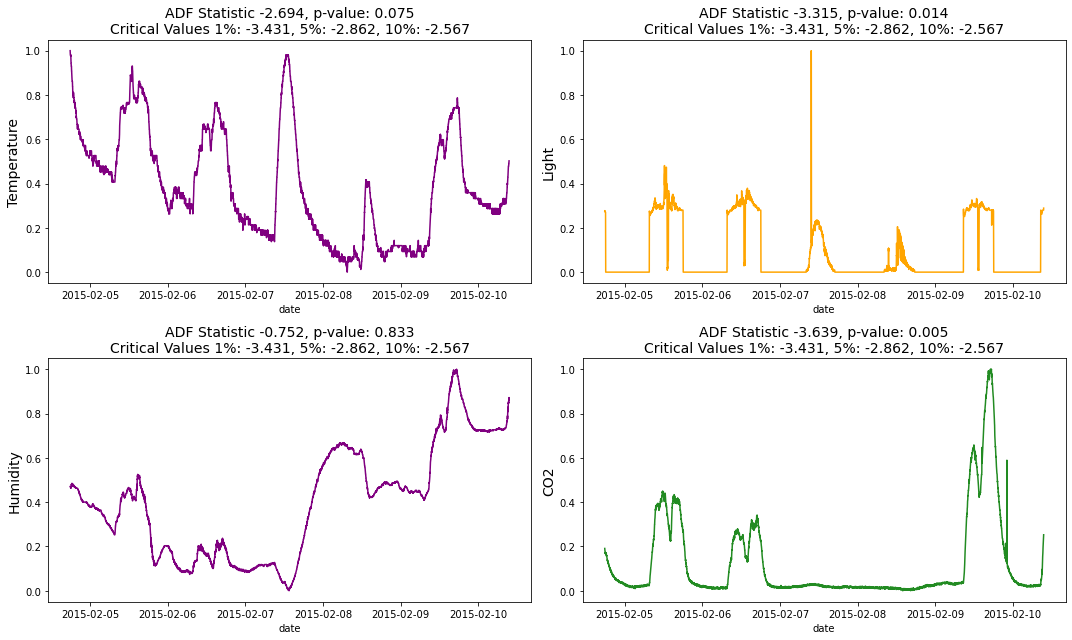

In [41]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=datatraining.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(datatraining['Temperature'].values, 'Temperature', ax[0, 0])
visualize_adfuller_results(datatraining['Humidity'].values, 'Humidity', ax[1, 0])
visualize_adfuller_results(datatraining['Light'].values, 'Light', ax[0, 1])
visualize_adfuller_results(datatraining['CO2'].values, 'CO2', ax[1, 1])
#visualize_adfuller_results(datatraining['HumidityRatio'].values, 'HumidityRatio', ax[2, 0])

plt.tight_layout()
plt.show()

non-stationary: Temperature, Humidity

stationary: CO2,Light

To use the ARIMA, the data requires stationary, so we can transformed it into stationary:

-Transformation: e.g. log or square root to stabilize non-constant variance

-Differencing: subtracts the current value from the previous

#### Transforming

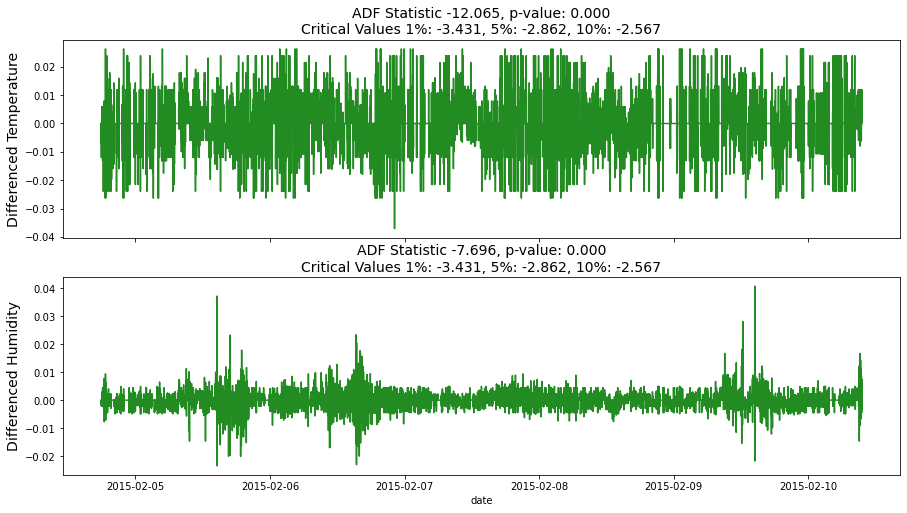

In [42]:
temp_diff = np.diff(datatraining['Temperature'])
datatraining['Temperature_diff'] = np.append([0], temp_diff)
humid_diff = np.diff(datatraining['Humidity'])
datatraining['Humidity_diff'] = np.append([0], humid_diff)

f, ax = plt.subplots(nrows=2, ncols=1,sharex=True, figsize=(15, 8))
visualize_adfuller_results(datatraining['Temperature_diff'], 'Differenced Temperature', ax[0])
visualize_adfuller_results(datatraining['Humidity_diff'], 'Differenced Humidity', ax[1])

In [43]:
datatraining

,Temperature,Humidity,Light,CO2,Occupancy,Temperature_diff,Humidity_diff
date,,,,,,,
2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,1,0.000000,0.000000
2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,1,-0.007177,-0.000201
2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,1,0.000000,-0.001006
2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,1,0.000000,-0.002011
2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,1,-0.011962,0.000000
...,...,...,...,...,...,...,...
2015-02-10 09:29:00,0.490431,0.865013,0.280017,0.231781,1,0.000000,0.002123
2015-02-10 09:29:59,0.490431,0.860431,0.280017,0.233173,1,0.000000,-0.004582
2015-02-10 09:30:59,0.502392,0.864901,0.280017,0.238744,1,0.011962,0.004470


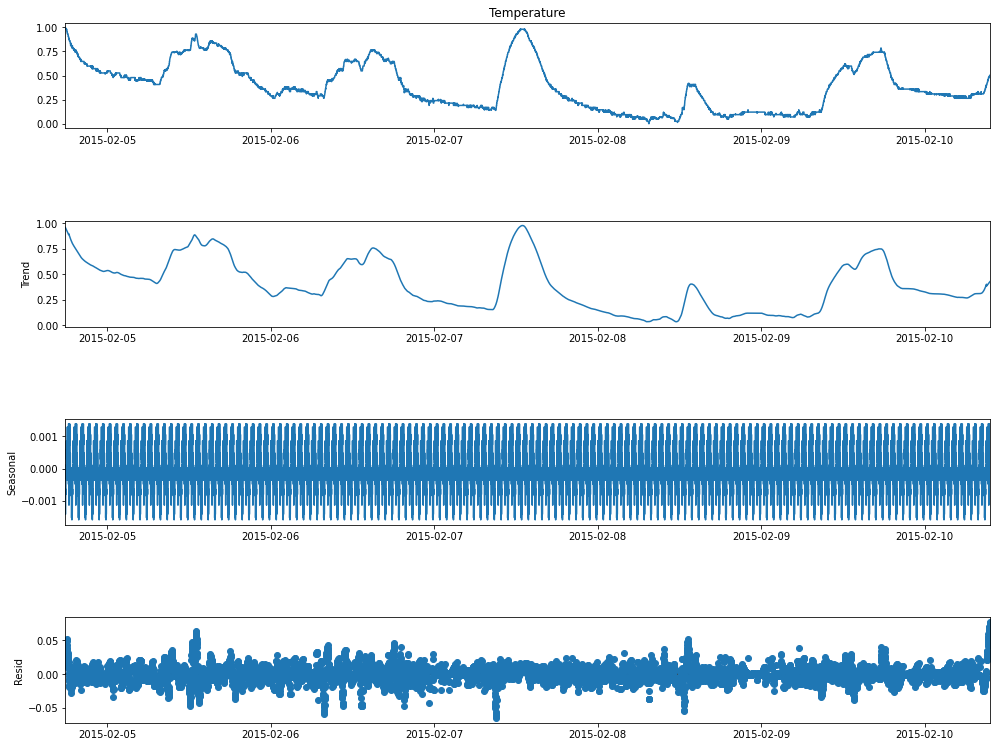

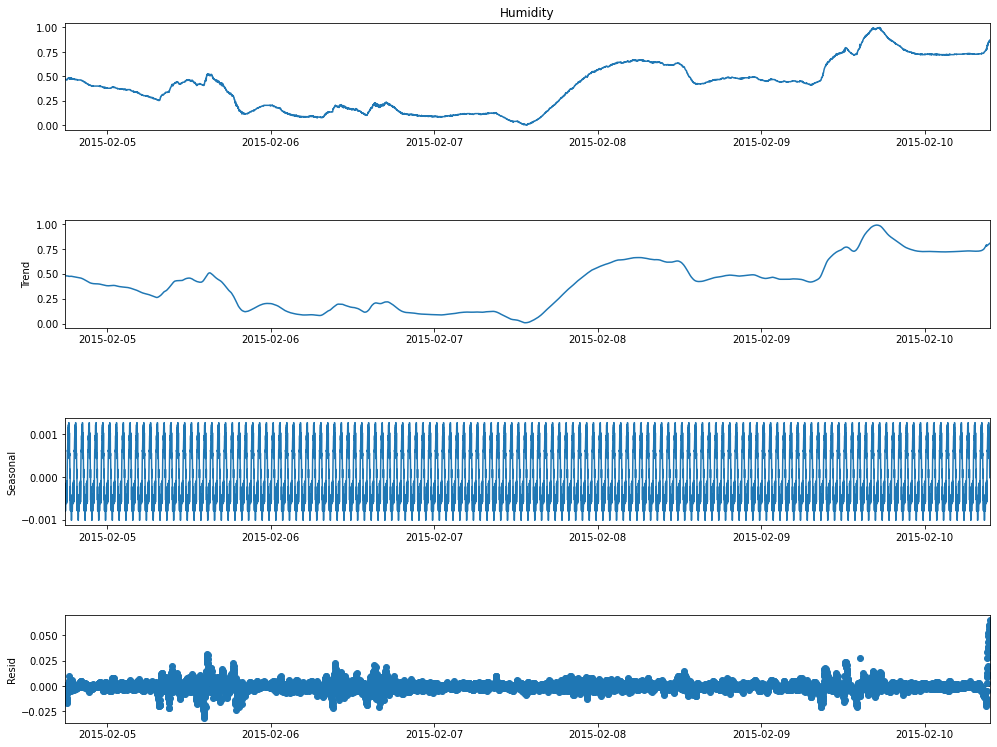

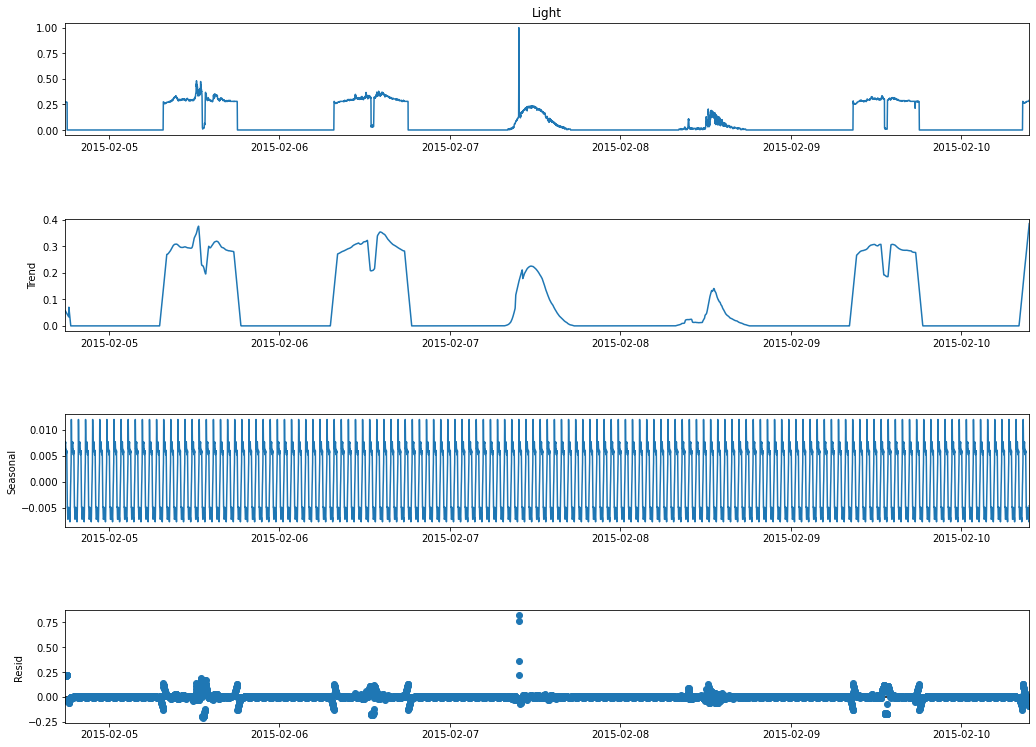

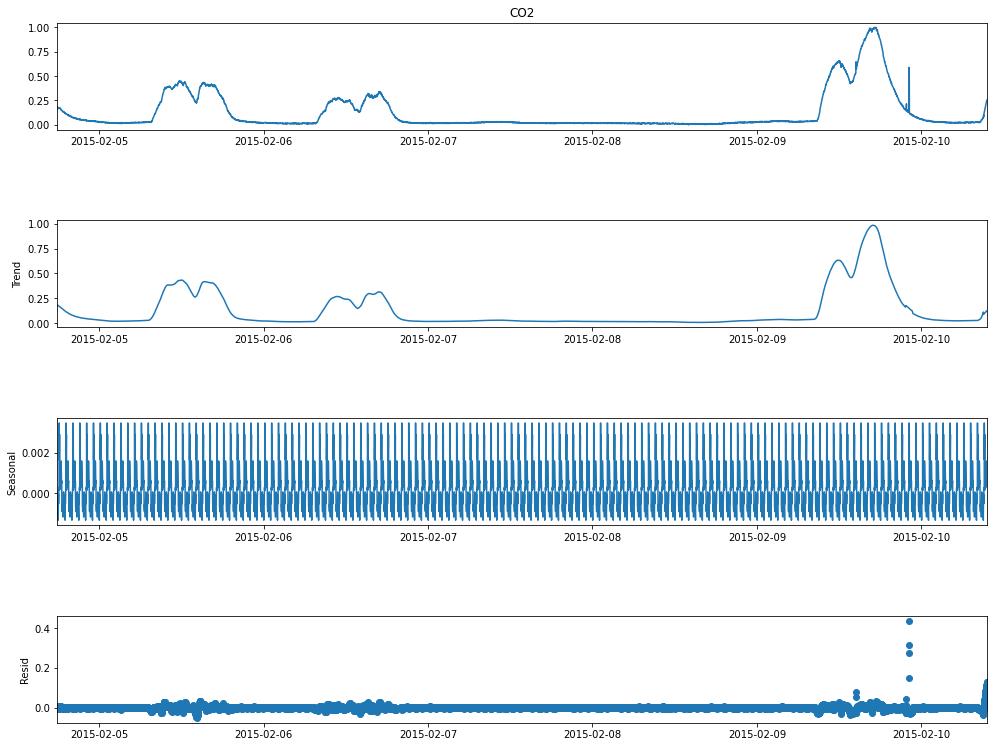

In [44]:
core_columns =  ['Temperature', 'Humidity', 'Light', 'CO2']

for column in core_columns:
    decomp = seasonal_decompose(datatraining[column], period=60, model='additive', extrapolate_trend='freq')
    #datatraining[f"{column}_trend"] = decomp.trend
    #datatraining[f"{column}_seasonal"] = decomp.seasonal
    fig = decomp.plot()
    fig.set_size_inches(16, 12)

The features now all stationary and seasonal

### Modelling

#### Prophet model

In [93]:
feature_columns = [
    'Temperature',
    'Humidity',
    'Light',
    'CO2'
]
target_column = ['Occupancy']

#train_size = int(0.85 * len(df))
train= datatraining.reset_index()
train= train[['date'] + target_column + feature_columns].copy()
train.columns = ['ds', 'y'] + feature_columns

test = datatest.reset_index()
test = test[['date'] + target_column + feature_columns].copy()
test.columns = ['ds', 'y'] + feature_columns

#train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(train.iloc[:, [0,2,3,4,5]]), pd.DataFrame(train.iloc[:, 1])
x_valid, y_valid = pd.DataFrame(test.iloc[:, [0,2,3,4,5]]), pd.DataFrame(test.iloc[:, 1])

In [95]:
train

,ds,y,Temperature,Humidity,Light,CO2
0,2015-02-04 17:51:00,1,1.000000,0.470533,0.275490,0.190933
1,2015-02-04 17:51:59,1,0.992823,0.470332,0.277754,0.186446
2,2015-02-04 17:53:00,1,0.992823,0.469326,0.275490,0.186136
3,2015-02-04 17:54:00,1,0.992823,0.467315,0.275490,0.182887
4,2015-02-04 17:55:00,1,0.980861,0.467315,0.275490,0.180566
...,...,...,...,...,...,...
8138,2015-02-10 09:29:00,1,0.490431,0.865013,0.280017,0.231781
8139,2015-02-10 09:29:59,1,0.490431,0.860431,0.280017,0.233173
8140,2015-02-10 09:30:59,1,0.502392,0.864901,0.280017,0.238744
8141,2015-02-10 09:32:00,1,0.502392,0.872276,0.280017,0.252256


In [46]:
model = Prophet()
model.add_regressor('Temperature')
model.add_regressor('Humidity')
model.add_regressor('Light')
model.add_regressor('CO2')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


RMSE: 0.34728882846190173


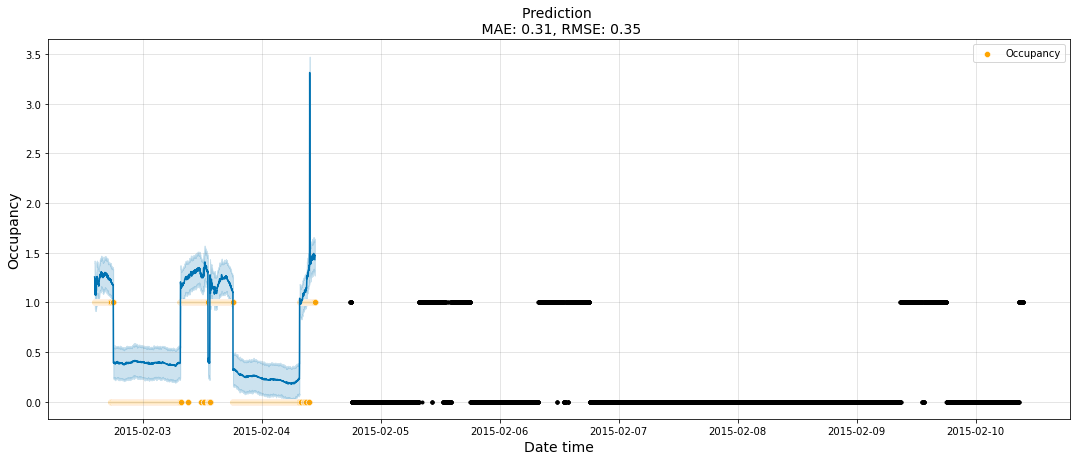

In [47]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.scatterplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Occupancy') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date time', fontsize=14)
ax.set_ylabel(ylabel='Occupancy', fontsize=14)

plt.show()

#### VAR model

In [96]:
train2 = datatraining[target_column + feature_columns].copy()
test2 = datatest[target_column + feature_columns].copy()

In [97]:
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()



In [98]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(train2)
model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(test2))


In [99]:

#converting predictions to dataframe
cols = train2.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,5):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], test2[i])))



rmse value for Occupancy is :  0.4739053317792925
rmse value for Temperature is :  0.34668325244598175
rmse value for Humidity is :  0.5978423808879012
rmse value for Light is :  0.16609385015048414
rmse value for CO2 is :  0.20854921164958093


<AxesSubplot:xlabel='date', ylabel='Actual_Occupancy'>

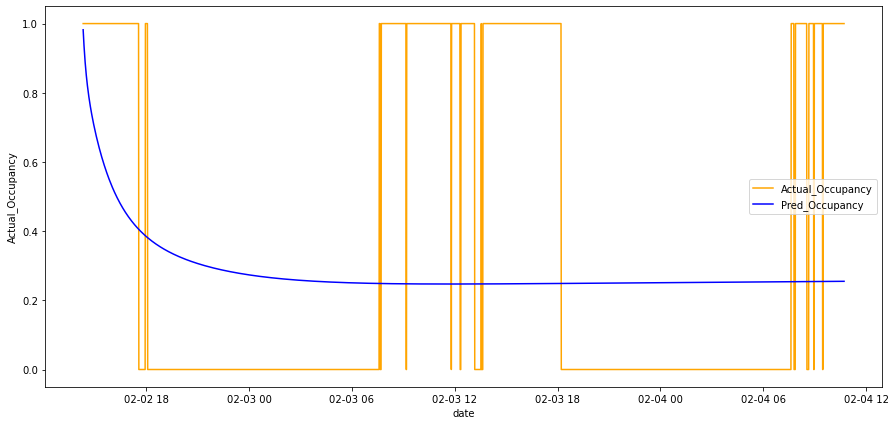

In [100]:
data = pd.concat([test,pred], axis=1)

data = data.iloc[:, [0,1,6]]
data.columns = ['date', 'Actual_Occupancy','Pred_Occupancy']

#data['Pred_Occupancy'] = [1 if x > 0.5 else 0 for x in data['Pred_Occupancy']]
data['Pred_Occupancy'] = data['Pred_Occupancy'].astype(float)

f, ax= plt.subplots(figsize=(15,7))
sns.lineplot(x=data['date'], y=data['Actual_Occupancy'], ax=ax, color='orange', label='Actual_Occupancy') 
sns.lineplot(x=data['date'], y=data['Pred_Occupancy'], ax=ax, color='blue', label='Pred_Occupancy') 